# Library

In [19]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

import mlflow
import mlflow.keras
from sklearn.metrics import accuracy_score

# Preprocessing

In [2]:
fnd_data_0=pd.read_csv('https://fnd-jedha-project.s3.eu-west-3.amazonaws.com/3_WELFake_Embedding_workbase.csv')
fnd_data_0.head()

,label,message,message_clean
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert follow threat cop w...
1,0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general charlotte...
2,1,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raise hindu use story christian c...
3,0,SATAN 2: Russia unvelis an image of its terrif...,satan 2 russia unvelis image terrifying new su...
4,0,About Time! Christian Group Sues Amazon and SP...,time christian group sue amazon splc designati...


In [3]:
fnd_data=fnd_data_0.sample(10000)

In [4]:
sentences = fnd_data['message_clean'].tolist()
labels = fnd_data['label'].tolist()

In [5]:
# Entraîner le modèle Word2Vec
embedding_dim = 8  # Dimension des vecteurs Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)


In [6]:
# Tokenizer Keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts([" ".join(sentence) for sentence in sentences])
vocab_size = len(tokenizer.word_index) + 1

In [7]:
# Créer une matrice d'embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [8]:
# Définir la longueur maximale des séquences
max_length = max(len(sentence) for sentence in sentences)

# Modelling

In [9]:
# Préparer les données d'entraînement
X_train = tokenizer.texts_to_sequences([" ".join(sentence) for sentence in sentences])
X_train = pad_sequences(X_train, maxlen=100, padding='post')
y_train = np.array(labels)

In [10]:
X_train.shape

(10000, 100)

In [11]:
y_train.shape

(10000,)

In [12]:

# Définir le modèle Keras
base_model = tf.keras.Sequential([
    # Couche d'Input Word Embedding avec la matrice d'embedding pré-entraînée
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True, name="embedding"),
    # Couche LSTM
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Global Average Pooling
    tf.keras.layers.GlobalAveragePooling1D(),
    # Couche Dense classique
    tf.keras.layers.Dense(64, activation='relu'),
    # Couche de sortie
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compilation du modèle
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        #tf.keras.metrics.Precision(),
        #tf.keras.metrics.Recall(),
        #tf.keras.metrics.AUC()
    ]
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-01-28 11:14:31.054995: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
# Entraînement du modèle
history=base_model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - binary_accuracy: 0.5404 - loss: 0.6900 - val_binary_accuracy: 0.5670 - val_loss: 0.6853
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5490 - loss: 0.6879 - val_binary_accuracy: 0.5670 - val_loss: 0.6839
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.5484 - loss: 0.6871 - val_binary_accuracy: 0.5690 - val_loss: 0.6827
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5404 - loss: 0.6875 - val_binary_accuracy: 0.5705 - val_loss: 0.6816
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - binary_accuracy: 0.5502 - loss: 0.6850 - val_binary_accuracy: 0.5725 - val_loss: 0.6807
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - binary_accuracy: 0.5402 - loss: 0.6868 - val_binary_accuracy: 0.5735 - val_loss: 0.6793
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - binary_accuracy: 0.5453 - loss: 0.6848 - val_binary_accuracy: 0.5750 - val_loss: 0.6777
Epoch 8/100
63/63 

## Check Metrics

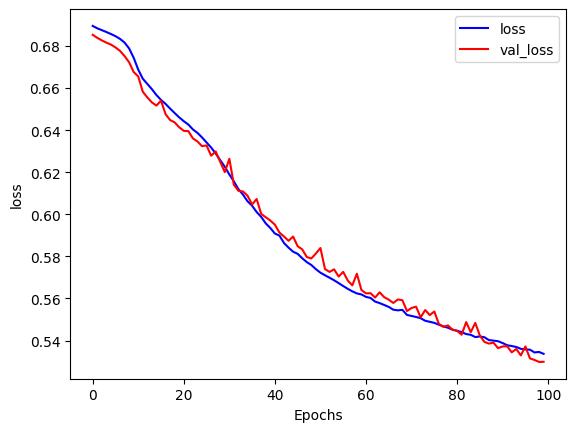

In [14]:
plt.plot(history.history['loss'], color='b', label='loss')
plt.plot(history.history['val_loss'], color='r', label='val_loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

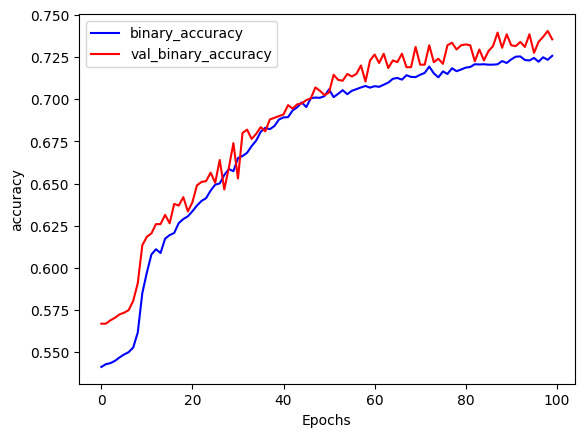

In [15]:
plt.plot(history.history['binary_accuracy'], color='b', label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], color='r', label='val_binary_accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# ML Flow - Log Model

In [20]:
# Configuration de MLflow
EXPERIMENT_NAME = "Fake News Detector - Word2vec Model"
mlflow.set_tracking_uri('https://fmendes13-fake-news-detector.hf.space')
mlflow.set_experiment(EXPERIMENT_NAME)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

# Activer l'autologging pour Keras
mlflow.keras.autolog()

# Démarrer une nouvelle run MLflow
with mlflow.start_run(experiment_id=experiment.experiment_id):
    # Entraînement du modèle Word2Vec
    word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    
    # Création de la matrice d'embedding
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

    # Construction du modèle Keras
    base_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True),
        tf.keras.layers.LSTM(16),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compilation du modèle
    base_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entraînement du modèle
    history = base_model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2)

    # Évaluation du modèle
    y_pred = (base_model.predict(X_train) > 0.5).astype("int32")
    accuracy = accuracy_score(y_train, y_pred)

    # Affichage des résultats
    print("Modèle Word2Vec + Keras")
    print(f"Accuracy sur l'ensemble d'entraînement : {accuracy}")

2025/01/28 11:32:43 INFO mlflow.tracking.fluent: Experiment with name 'Fake News Detector - Word2vec Model' does not exist. Creating a new experiment.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2025/01/28 11:33:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Failed to upload /tmp/tmpztu_e5jd/model_summary.txt to fnd-jedha-project/9/f7e8b336d90b47638a0b370a6bcfc30d/artifacts/model_summary.txt: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5490 - loss: 0.6906 - val_accuracy: 0.5775 - val_loss: 0.6824
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5530 - loss: 0.6871 - val_accuracy: 0.5765 - val_loss: 0.6803
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5524 - loss: 0.6843 - val_accuracy: 0.5770 - val_loss: 0.6782
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5485 - loss: 0.6829 - val_accuracy: 0.5760 - val_loss: 0.6761
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5477 - loss: 0.6792 - val_accuracy: 0.5740 - val_loss: 0.6740
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5546 - loss: 0.6764 - val_accuracy: 0.6085 - val_loss: 0.6719
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6070 - loss: 0.6742 - val_accuracy: 0.6230 - val_loss: 0.6696
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6047 - loss: 0.6727 - val_accuracy: 0.

2025/01/28 11:35:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Failed to upload /tmp/tmphb8lh2h2/model/requirements.txt to fnd-jedha-project/9/f7e8b336d90b47638a0b370a6bcfc30d/artifacts/model/requirements.txt: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Modèle Word2Vec + Keras
Accuracy sur l'ensemble d'entraînement : 0.7329
🏃 View run invincible-sow-174 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/9/runs/f7e8b336d90b47638a0b370a6bcfc30d
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/9
